When we get the output data from variable processing (MEI.v2_Variable_Processing) it is functionally 4D (number of varaibles (5) x latitude x longitude x time). We can put the different variables in as different channels for the informer, but that still essentially gives us a 3D input--which won't work! Moreover, because of the nature of the data, the positions of the values within the 3D lat x lon x time grid probably matter--ex. where it's warm versus cool in the SST probably makes a difference, in the same way that you can't just shake around the order of words in a sentence and have it make sense.

The solution to both of these problems is positional encodings, i.e. adding something to each of the values that gives it a "tag" for its position. In our case, this means tagging latitutde, longitude, and time into the data for each of the 5 climate varaibles, then flattening and inputting the data into the informer.

I'm following from the instructions here: https://github.com/tatp22/multidim-positional-encoding
(and using their positional encodings).

In [2]:
import torch
from positional_encodings.torch_encodings import PositionalEncoding1D, PositionalEncoding2D, PositionalEncoding3D, Summer
import numpy as np
import matplotlib.pyplot as plt

In [31]:
# import the processed climate varaibles

standardized_pressure = np.load('standardized_pressure.npy')
standardized_temperature = np.load('standardized_temperature.npy')
standardized_uwind = np.load('standardized_uwind.npy')
standardized_vwind = np.load('standardized_vwind.npy')
standardized_olr = np.load('standardized_olr.npy')


# and just see the shape of one of these 3D arrays
# latitude x longitude x time
# where time is months from January 1979 - December 2022
standardized_pressure.shape

(15, 48, 516)

According to the Github above, the 3D positional encoding goes as:

PE(x,y,z,2i) = sin(x/10000^(6i/D))

PE(x,y,z,2i+1) = cos(x/10000^(6i/D))

PE(x,y,z,2j+D/3) = sin(y/10000^(6j/D))

PE(x,y,z,2j+1+D/3) = cos(y/10000^(6j/D))

PE(x,y,z,2k+2D/3) = sin(z/10000^(6k/D))

PE(x,y,z,2k+1+2D/3) = cos(z/10000^(6k/D))


Where:
(x,y,z) is a point in 3d space; i,j,k is an integer in [0, D/6), where D is the size of the ch dimension

torch.Size([1, 10])


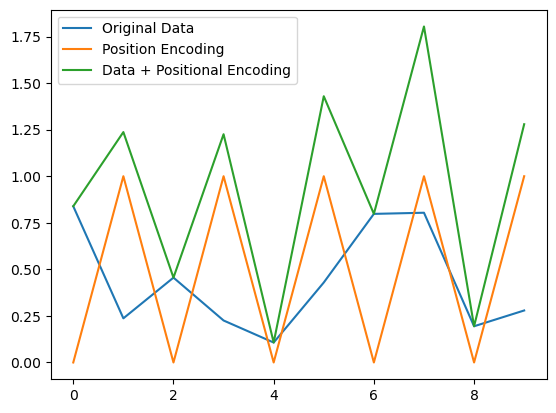

In [18]:
"""
The 3D positional encoding works on data of the shape (batchsize, x, y, z, ch).

Thus, we should have input data of the shape

For now, I'm just leaving batchsize = 1 to leave the data all in one big glob of time + position. I'm thinking
we'll split it into separate batches (little chunks of timeseries?) after the positional encoding when we input
into the informer, but I'm honestly not sure that that's the best approach, so it might take some tinkering.

"""

# Just doing a 1D test for the moment, just to try out the positional encoding!
# This test comes right from the GitHub linked above.

# Returns the position encoding only
p_enc_1d_model = PositionalEncoding1D(10)

# Return the inputs with the position encoding added
p_enc_1d_model_sum = Summer(PositionalEncoding1D(10))

x = torch.rand(1,20,10)
penc_no_sum = p_enc_1d_model(x) # penc_no_sum.shape == (1, 6, 10)
penc_sum = p_enc_1d_model_sum(x)
# print(penc_no_sum + x == penc_sum)

plt.plot(x[:,0,:].flatten(), label='Original Data')
plt.plot(penc_no_sum[:,0,:].flatten(), label='Position Encoding')
plt.plot(penc_sum[:,0,:].flatten(), label='Data + Positional Encoding')
plt.legend()

print(x[:,0,:].shape)

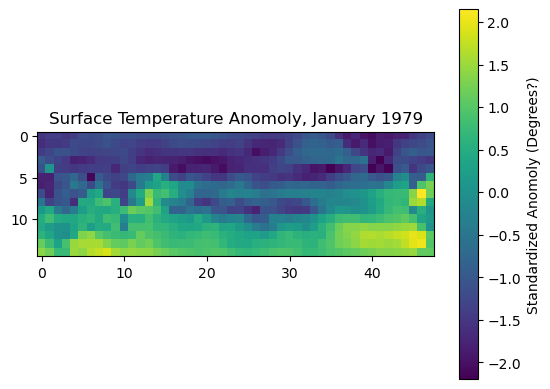

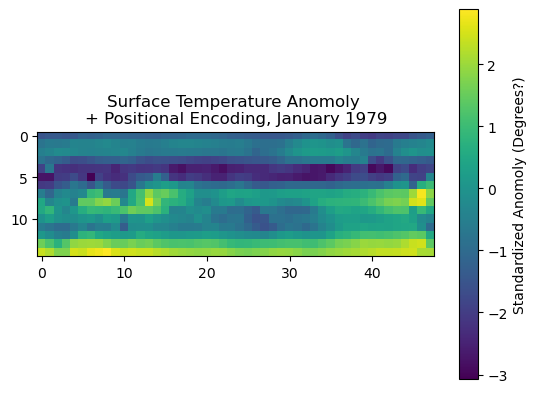

In [40]:
# and now trying on the real data

# I could concatenate the 5 varaibles into 5 channels, but that seems sort of silly?
# So I just did each of them separately

# First plot the original, just plotting the first month of SST
plt.imshow(standardized_temperature[:,:,0])
plt.colorbar(label="Standardized Anomoly (Degrees?)")
plt.title("Surface Temperature Anomoly, January 1979")
plt.show()

temperature = torch.from_numpy(standardized_temperature.reshape((1, 15, 48, 516, 1)))

# Return the inputs with the position encoding added
pos_enc_3D = Summer(PositionalEncoding3D(1))

temperature_withpos = pos_enc_3D(temperature)

# now plot the data with the positional encoding
plt.imshow(temperature_withpos.reshape((15, 48, 516))[:,:,0])
plt.colorbar(label="Standardized Anomoly (Degrees?)")
plt.title("Surface Temperature Anomoly \n+ Positional Encoding, January 1979")
plt.show()

In [ ]:
# and now just do the pos encoding for all of the variables

temperature = torch.from_numpy(standardized_temperature.reshape((1, 15, 48, 516, 1)))
temperature_withpos = pos_enc_3D(temperature)

pressure = torch.from_numpy(standardized_pressure.reshape((1, 15, 48, 516, 1)))
pressure_withpos = pos_enc_3D(pressure)

temperature = torch.from_numpy(standardized_uwind.reshape((1, 15, 48, 516, 1)))
temperature_withpos = pos_enc_3D(temperature)

temperature = torch.from_numpy(standardized_temperature.reshape((1, 15, 48, 516, 1)))
temperature_withpos = pos_enc_3D(temperature)

temperature = torch.from_numpy(standardized_temperature.reshape((1, 15, 48, 516, 1)))
temperature_withpos = pos_enc_3D(temperature)